---

## THIS NOTEBOOK HAVE THE BASE CODE TO CREATE A MAP WITH REAL-TIME FIRES

---

In [1]:
# we need to install some libraries as they are not default on the system
!pip install geodatasets cartopy

import geopandas
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from geodatasets import get_path

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 31.3 MB/s eta 0:00:00


---

## Mapping

---

Let's use our sample VIIRS SNPP dataset (~6MB) from **July 12th 2023** with time range from **0:00 to 19:50** (7:50pm) **GMT**. To better understand the sample dataset, please review module '*Data Ingest and Manipulation in Python*'.

In [13]:
# Let's set your map key that was emailed to you. It should look something like 'abcdef1234567890abcdef1234567890'
MAP_KEY = '0d4670ee1e60130f31ee3d7e88f78d7c'
#MAP_KEY = 'abcdef1234567890abcdef1234567890'

# now let's check how many transactions we have
import pandas as pd
url = 'https://firms.modaps.eosdis.nasa.gov/mapserver/mapkey_status/?MAP_KEY=' + MAP_KEY
try:
  df = pd.read_json(url,  typ='series')
  display(df)
except:
  # possible error, wrong MAP_KEY value, check for extra quotes, missing letters
  print ("There is an issue with the query. \nTry in your browser: %s" % url)

transaction_limit             1000
current_transactions             0
transaction_interval    10 minutes
dtype: object

In [153]:
#fire= 'https://firms.modaps.eosdis.nasa.gov/api/country/csv/'+ MAP_KEY+'/MODIS_NRT/MEX/1/2023-10-07'
# /api/area/csv/[MAP_KEY]/[SOURCE]/[AREA_COORDINATES]/[DAY_RANGE]
coordinates= 'https://firms.modaps.eosdis.nasa.gov/api/area/csv/'+ MAP_KEY+'/VIIRS_NOAA20_NRT/-107,17,-95,23/2'
df_mex = pd.read_csv(coordinates)
df_mex

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight
0,20.52164,-100.92532,297.77,0.42,0.45,2023-10-07,843,1,VIIRS,n,2.0NRT,276.18,1.30,N
1,20.52455,-100.92565,315.78,0.42,0.45,2023-10-07,843,1,VIIRS,n,2.0NRT,273.95,2.70,N
2,20.52573,-100.92445,310.24,0.42,0.45,2023-10-07,843,1,VIIRS,n,2.0NRT,273.48,1.30,N
3,18.96757,-97.96542,305.86,0.35,0.56,2023-10-07,845,1,VIIRS,n,2.0NRT,279.28,1.01,N
4,19.79336,-105.19180,331.61,0.51,0.41,2023-10-07,1955,1,VIIRS,n,2.0NRT,292.57,4.63,D
5,19.79350,-105.18902,334.28,0.51,0.41,2023-10-07,1955,1,VIIRS,n,2.0NRT,293.45,4.81,D
6,20.52420,-100.92361,336.55,0.38,0.36,2023-10-07,1955,1,VIIRS,n,2.0NRT,297.95,3.96,D
7,20.57527,-101.17175,335.85,0.38,0.36,2023-10-07,1955,1,VIIRS,n,2.0NRT,299.91,6.50,D
8,20.57693,-101.17316,295.07,0.40,0.40,2023-10-08,826,1,VIIRS,n,2.1URT,279.76,1.23,N


In [154]:
import pandas as pd

# Leer el archivo CSV en un DataFrame
df = df_mex

# Crear columnas redondeadas para latitud y longitud
df['rounded_latitude'] = df['latitude'].round(2)
df['rounded_longitude'] = df['longitude'].round(2)

# Encontrar las filas duplicadas en las columnas redondeadas
duplicates = df.duplicated(subset=['rounded_latitude', 'rounded_longitude'], keep='last')

# Obtener las filas que no son duplicadas
df_no_duplicates = df[~duplicates]

# Eliminar las columnas redondeadas si no las necesitas
df_no_duplicates = df_no_duplicates.drop(['rounded_latitude', 'rounded_longitude'], axis=1)

# Guardar el DataFrame resultante en un nuevo archivo CSV
df_no_duplicates.to_csv('nuevo_archivo.csv', index=False)


In [155]:
# Leer el archivo CSV en un DataFrame
df = pd.read_csv('nuevo_archivo.csv')

# Imprimir el contenido del DataFrame en la consola
print(df)

   latitude  longitude  bright_ti4  scan  track    acq_date  acq_time  \
0  20.52455 -100.92565      315.78  0.42   0.45  2023-10-07       843   
1  20.52573 -100.92445      310.24  0.42   0.45  2023-10-07       843   
2  18.96757  -97.96542      305.86  0.35   0.56  2023-10-07       845   
3  19.79350 -105.18902      334.28  0.51   0.41  2023-10-07      1955   
4  20.52420 -100.92361      336.55  0.38   0.36  2023-10-07      1955   
5  20.57693 -101.17316      295.07  0.40   0.40  2023-10-08       826   

   satellite instrument confidence version  bright_ti5   frp daynight  
0          1      VIIRS          n  2.0NRT      273.95  2.70        N  
1          1      VIIRS          n  2.0NRT      273.48  1.30        N  
2          1      VIIRS          n  2.0NRT      279.28  1.01        N  
3          1      VIIRS          n  2.0NRT      293.45  4.81        D  
4          1      VIIRS          n  2.0NRT      297.95  3.96        D  
5          1      VIIRS          n  2.1URT      279.76  

In [157]:
# now convert latitude, longitude values into point geometry

gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

# show top 3 records
gdf.head(3)

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,geometry
0,20.52455,-100.92565,315.78,0.42,0.45,2023-10-07,843,1,VIIRS,n,2.0NRT,273.95,2.70,N,POINT (-100.92565 20.52455)
1,20.52573,-100.92445,310.24,0.42,0.45,2023-10-07,843,1,VIIRS,n,2.0NRT,273.48,1.30,N,POINT (-100.92445 20.52573)
2,18.96757,-97.96542,305.86,0.35,0.56,2023-10-07,845,1,VIIRS,n,2.0NRT,279.28,1.01,N,POINT (-97.96542 18.96757)


**Note**: gdf is the same as df, except there is an extra column called 'geometry'

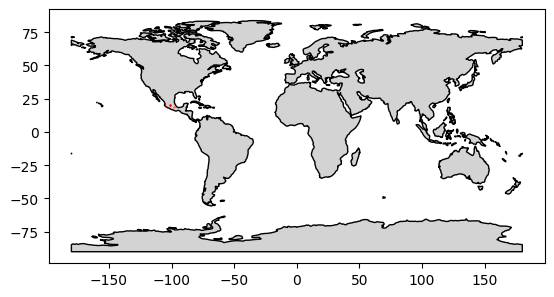

In [158]:
# optional: set outline and fill colors
ax = world.plot(color="lightgrey", edgecolor="black")

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color="red", markersize=0.1)

plt.show()


---
Let's subset our dataset to show fire detections in or near Canada using FIRMS [Regional Coordinates](https://firms.modaps.eosdis.nasa.gov/active_fire/coordinates.html)

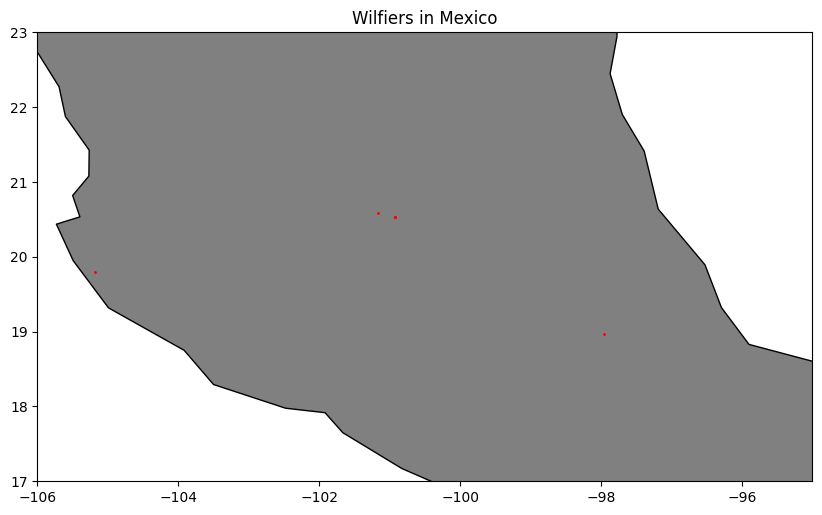

In [168]:
# create Canada subset
#.107,17,-95,23

df1= df[(df['longitude'] >= -170) & (df['latitude'] >= 17) & (df['longitude'] <= -95) & (df['latitude'] <= 23)].copy()

# create geometry for points using latitude and longitude and specifying projection as EPSG:4326

gdf = geopandas.GeoDataFrame(
    df1, geometry=geopandas.points_from_xy(df1.longitude, df1.latitude), crs="EPSG:4326"
)

# set our extent
extent = [-106, 17, -95, 23]
ax = world.plot(figsize=(10, 10), color="grey", edgecolor="black")
ax.set_xlim([extent[0],  extent[2]])
ax.set_ylim([extent[1],  extent[3]])

ax.set(title='Wilfiers in Mexico')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color="red", markersize=1)

plt.show()


---

## Time Since Detection

---

To further expand on our data, let's visualize it based on time when it was detected, so newer data has different color.

In this exercise, we will assume that **current date and time** is **2023 July 12, 19:50 (7:50pm) GMT** time. We will color code our detections:
- dark red; detections <= 1 hour
- red; detections > 1 hour but less than or equal to 4 hours
- orange; detections > 4hours and less than or equal to 12 hours
- yellow; detections older than 12 hours

To explain the datetime conversion and to better understand GMT / local time zones, please see module '*Data Ingest and Manipulation in Python*'

In [169]:
# convert aqc_date and aqc_time to acq_datetime as datetime object
df1['acq_datetime'] = pd.to_datetime(df1['acq_date'] + ' ' + df1['acq_time'].astype(str).str.zfill(4), format='%Y-%m-%d %H%M')
gdf = geopandas.GeoDataFrame(
    df1, geometry=geopandas.points_from_xy(df1.longitude, df1.latitude), crs="EPSG:4326"
)
# find maximum time from our dataset since we are pretending current date time is July 12 2023, 19:50(7:50pm) GMT.
# if the data were recent, we would set dt_max = pd.Timestamp.now();
dt_max = gdf['acq_datetime'].max()

# create our subsets for 4 color classes

# less than or equal to 1 hour; gdf1 <= 1hour
gdf1 = gdf[gdf['acq_datetime'] >= (dt_max - pd.Timedelta(hours=1))]

# greater than 1 hour but less than or equal to 4 hours; gdf2 > 1 hour and gdf2 <= 4 hours
gdf2 = gdf[(gdf['acq_datetime'] >= (dt_max - pd.Timedelta(hours=4))) & (gdf['acq_datetime'] < (dt_max - pd.Timedelta(hours=1)))]

# greater than 4 hours but less than or equal to 12 hours; gdf3 > 4 hours and gdf2 <= 12 hours
gdf3 = gdf[(gdf['acq_datetime'] >= (dt_max - pd.Timedelta(hours=12))) & (gdf['acq_datetime'] < (dt_max - pd.Timedelta(hours=4)))]

# greater than 12 hours; gdf4 > 12 hours
gdf4 = gdf[gdf['acq_datetime'] < (dt_max - pd.Timedelta(hours=12))]

# now let's make sure the sizes are correct. They should all add up to 14045
print ('Sizes %i, %i, %i, %i from total of %i' % (gdf1.count()[0],gdf2.count()[0],gdf3.count()[0],gdf4.count()[0], gdf.count()[0]))

Sizes 1, 0, 0, 5 from total of 6


ValueError: ignored

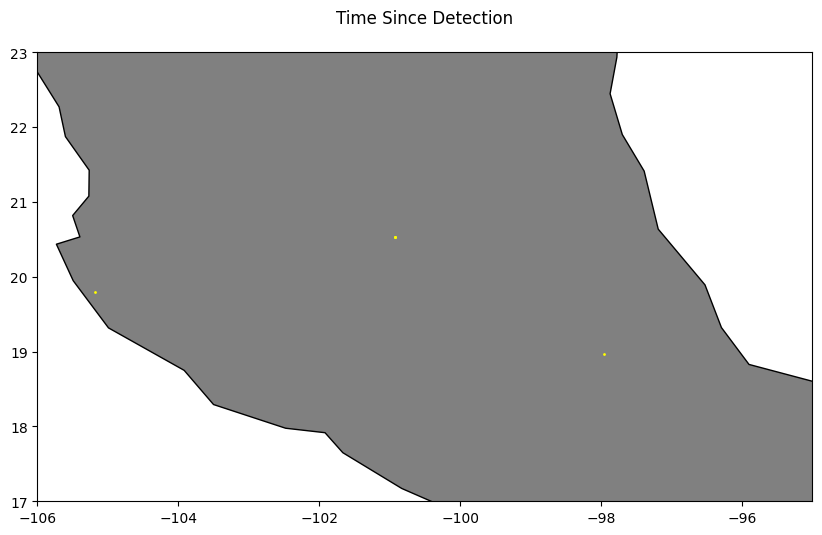

In [171]:
# set our extent to Canada
extent = [-106, 17, -95, 23]
ax = world.plot(figsize=(10, 10), color="grey", edgecolor="black")

# set map extent
ax.set_xlim([extent[0],  extent[2]])
ax.set_ylim([extent[1],  extent[3]])

# add graph title
ax.set(title='Time Since Detection\n')

# Color code each set; also we are drawing in opposite order, so the older detections are drawn first so the newer ones are on the top
gdf4.plot(ax=ax, color="yellow", markersize=1)
gdf3.plot(ax=ax, color="orange", markersize=1)
gdf2.plot(ax=ax, color="red", markersize=1)
gdf1.plot(ax=ax, color="darkred", markersize=1)

plt.show()

---
At last, let's add some more detailed information to our map so our viewers can better understand the location of these fire detection.

In [10]:
!pip install contextily
import contextily as cx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 11.8 MB/s eta 0:00:00


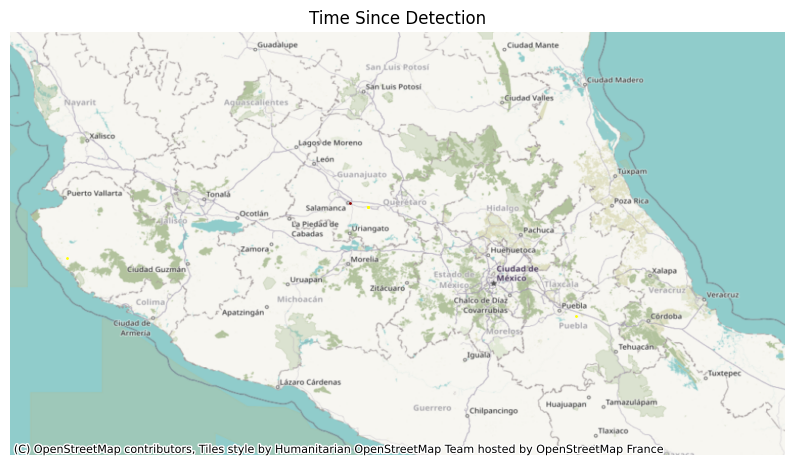

In [172]:
extent = [-106, 17, -95, 23]
ax = world.plot(figsize=(10, 10), alpha=0)

# set our map extent
ax.set_xlim([extent[0],  extent[2]])
ax.set_ylim([extent[1],  extent[3]])

# set title
ax.set(title='Time Since Detection')
# turn off axis labels
ax.set_axis_off()

# Color code each set; also we are drawing in opposite order, so the older detections are drawn first so the newer ones are on the top
if gdf4.count()[0] > 0 :
  gdf4.plot(ax=ax, color="yellow", markersize=1)
if gdf3.count()[0] > 0 :
  gdf3.plot(ax=ax, color="orange", markersize=1)
if gdf2.count()[0] > 0 :
  gdf2.plot(ax=ax, color="red", markersize=1)
if gdf1.count()[0] > 0 :
  gdf1.plot(ax=ax, color="darkred", markersize=1)

# add basemap
cx.add_basemap(ax, crs=gdf1.crs)

# show our map plot
plt.show()
